In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
# set up training set
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [4]:
print(train_v.shape)
print(test_v.shape)

(2520000, 182)
(282688, 182)


In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)

In [6]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
#print('Unique LL_PDC:', np.unique(train_v[:, 28]))

LL_PDC: 28


In [7]:
def setup_xy(time_series, scaled_time_series):
    num_of_inds = time_series.shape[0]//28
    print("Number of inds:", num_of_inds)
    num_of_features = time_series.shape[1]
    print("Number of features:", num_of_features)
    x = np.empty((num_of_inds, 8, num_of_features))
    # creating 2 binary vectors for softmax 
    # non-adherent and adherent
    y = np.empty((num_of_inds, 2))

    for i in range(num_of_inds):
        ind_v = time_series[(i*28):((i+1)*28), :]
        if (sum(ind_v[8:28, 28])/20) >= 80:
            y[i, 0] = 0.0
            y[i, 1] = 1.0
        else:
            y[i, 0] = 1.0
            y[i, 1] = 0.0
        scaled_ind_v = scaled_time_series[(i*28):((i+1)*28), :]
        x[i] = scaled_ind_v[:8, :]
    return x, y

In [8]:
x_train, y_train = setup_xy(train_v, scaled_train)
x_test, y_test = setup_xy(test_v, scaled_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of inds: 90000
Number of features: 182
Number of inds: 10096
Number of features: 182
(90000, 8, 182)
(90000, 2)
(10096, 8, 182)
(10096, 2)


In [9]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

9000


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.8915 - acc: 0.5652 - val_loss: 0.8298 - val_acc: 0.6053

Epoch 00001: val_loss improved from inf to 0.82980, saving model to PDC_val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7825 - acc: 0.6369 - val_loss: 0.7466 - val_acc: 0.6647

Epoch 00002: val_loss improved from 0.82980 to 0.74657, saving model to PDC_val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.7135 - acc: 0.6808 - val_loss: 0.6915 - val_acc: 0.6952

Epoch 00003: val_loss improved from 0.74657 to 0.69151, saving model to PDC_val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.6665 - acc: 0.7063 - val_loss: 0.6524 - val_acc: 0.7119

Epoch 00004: val_loss improved from 0.69151 to 0.65239, saving model to PDC_val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.6330 - acc: 0.7191 - val_loss: 0.6240 - val_acc: 0.7194

Epoch 00005: val_loss improved fro


Epoch 00044: val_loss did not improve from 0.53021
Epoch 45/100
 - 1s - loss: 0.5248 - acc: 0.7520 - val_loss: 0.5304 - val_acc: 0.7481

Epoch 00045: val_loss did not improve from 0.53021
Epoch 46/100
 - 1s - loss: 0.5246 - acc: 0.7521 - val_loss: 0.5304 - val_acc: 0.7484

Epoch 00046: val_loss did not improve from 0.53021
Epoch 47/100
 - 1s - loss: 0.5244 - acc: 0.7520 - val_loss: 0.5303 - val_acc: 0.7480

Epoch 00047: val_loss did not improve from 0.53021
Epoch 48/100
 - 1s - loss: 0.5243 - acc: 0.7520 - val_loss: 0.5303 - val_acc: 0.7481

Epoch 00048: val_loss did not improve from 0.53021
Epoch 49/100
 - 1s - loss: 0.5241 - acc: 0.7520 - val_loss: 0.5303 - val_acc: 0.7478

Epoch 00049: val_loss did not improve from 0.53021
Epoch 50/100
 - 1s - loss: 0.5240 - acc: 0.7520 - val_loss: 0.5302 - val_acc: 0.7480

Epoch 00050: val_loss improved from 0.53021 to 0.53018, saving model to PDC_val_weights1.hdf5
Epoch 51/100
 - 1s - loss: 0.5238 - acc: 0.7521 - val_loss: 0.5301 - val_acc: 0.747

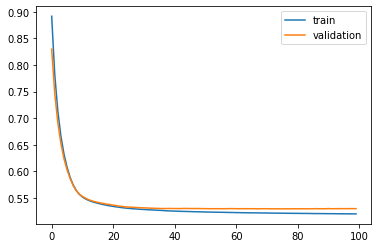

(10096, 2)


In [10]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

units = 8
batch_s = 4096

L2_1 = 0.012024274240680552
#L2_2 = 1.4771031289939846e-08

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train2_y, train1_y, axis=0)

    start_time_inner = time.time()
    #config = tf.ConfigProto(log_device_placement = True)
    #config.gpu_options.visible_device_list='1'
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        model.add(SimpleRNN(units, #CuDNNLSTM
                            kernel_regularizer=regularizers.l2(L2_1),
                            #return_sequences=True, 
                            input_shape=(8, 182))) #20 , 27
        #model.add(CuDNNLSTM(units, 
        #                   kernel_regularizer=regularizers.l2(L2_2)))
                            #return_sequences=True))
        model.add(Dense(2, activation='softmax'))
        #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
        #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', metrics=['accuracy'])
        val_weight = "PDC_val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                            epochs=100, validation_split=0.1, 
                            callbacks=[val_checkpointer], 
                            verbose=2, 
                            shuffle=False) 
        print("#################################")
        print("Number of units:", units)
        print("Batch size:", batch_s)
        print("Fold:", f)
        print("best val loss:", min(history.history['val_loss']))
        print("#################################")
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print(yhat_test.shape)

In [11]:
print(yhat_test.shape)
yhat_test_df = pd.DataFrame(yhat_test)
y_test_df = pd.DataFrame(y_test)
yhat_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
y_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
feather.write_dataframe(yhat_test_df, "/home/whsu014/data/PDC_SimpleRNN_1layer_yhat.feather")
#feather.write_dataframe(y_test_df, "/home/whsu014/data/PDC_y.feather")

(10096, 2)


In [6]:
#############################
# Multi PDC EVENT
#############################
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_PDC_LSTM_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_PDC_LSTM_Sample_Weight_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_PDC_LSTM_IFC_Patched_yhat.feather")
#lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Multi_PDC_LSTM_IFC_Patched_Sample_Weight_yhat.feather")

lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LSTM_1layer_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_SimpleRNN_1layer_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_MLP_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_yhat.feather")
#rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_aggregated_yhat.feather")
#rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_last_quarter_yhat.feather")
#rc_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_MINMAX_normalized_yhat.feather")
rc_a_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_aggregated_MINMAX_normalized_yhat.feather")
rc_l_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_last_quarter_MINMAX_normalized_yhat.feather")
rc_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_LR_NO_ID_yhat.feather")

#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_1_notcovered_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_normalized_yhat.feather")
######lr_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_normalized_no_penalty_yhat.feather")
#lr_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_NO_ID_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_yhat_10000iter.feather")

#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_aggregated_yhat.feather")
#lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_aggregated_normalized_yhat.feather")
#####lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_aggregated_normalized_no_penalty_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_aggregated_yhat_2000iter.feather")

#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_last_quarter_yhat.feather")
#lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_last_quarter_normalized_yhat.feather")
#####lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_last_quarter_normalized_no_penalty_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/PDC_Logit_last_quarter_yhat_2000iter.feather")


cox_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_PDC_aggregated_yhat_10096inds.feather")
cox_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Cox_PDC_last_quarter_yhat_10096inds.feather")

y_df = feather.read_dataframe("/home/whsu014/data/PDC_y.feather")
#y_mlp_df = feather.read_dataframe("/home/whsu014/data/PDC_y_MLP.feather")
lstm_yhat = lstm_yhat_df.values
rnn_yhat = rnn_yhat_df.values
mlp_yhat = mlp_yhat_df.values
rc_yhat = rc_yhat_df.values
rc_a_yhat = rc_a_yhat_df.values
rc_l_yhat = rc_l_yhat_df.values
lr_yhat = lr_yhat_df.values
lr_a_yhat = lr_a_yhat_df.values
lr_l_yhat = lr_l_yhat_df.values
cox_a_yhat = cox_a_yhat_df.values
cox_l_yhat = cox_l_yhat_df.values
y = y_df.values
#lr_yhat = 1 - lr_yhat

LSTM:			ROC AUC = 0.805
RNN:			ROC AUC = 0.798
MLP:			ROC AUC = 0.794
RC:			ROC AUC = 0.784
RC (aggregated):	ROC AUC = 0.766
RC (last quarter):	ROC AUC = 0.766
LR:			ROC AUC = 0.776
LR (aggregated):	ROC AUC = 0.764
LR (last quarter):	ROC AUC = 0.765
Cox (aggregated):	ROC AUC = 0.762
Cox (last quarter):	ROC AUC = 0.763


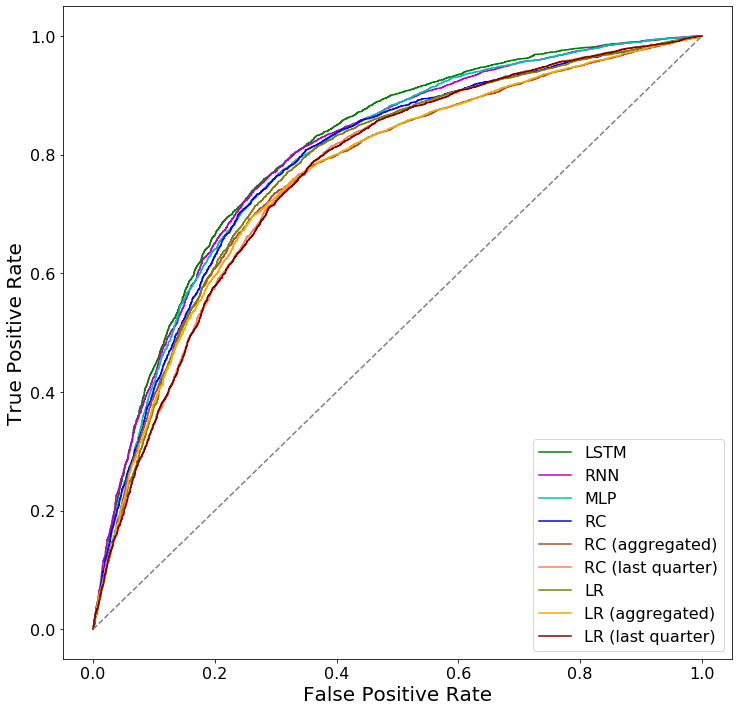

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fs = 20
lstm_auc = roc_auc_score(y[:, 1], 
                         lstm_yhat[:, 1])
rnn_auc = roc_auc_score(y[:, 1],
                         rnn_yhat[:, 1])
mlp_auc = roc_auc_score(y[:, 1],
                         mlp_yhat[:, 1])
rc_auc = roc_auc_score(y[:, 1], 
                          rc_yhat[:, 0])
rc_a_auc = roc_auc_score(y[:, 1], 
                          rc_a_yhat[:, 0])
rc_l_auc = roc_auc_score(y[:, 1],
                         rc_l_yhat[:, 0])
lr_auc = roc_auc_score(y[:, 1],
                         lr_yhat[:, 0])
lr_a_auc = roc_auc_score(y[:, 1],
                         lr_a_yhat[:, 0])
lr_l_auc = roc_auc_score(y[:, 1],
                         lr_l_yhat[:, 0])
cox_a_auc = roc_auc_score(y[:, 1],
                         cox_a_yhat[:, 0])
cox_l_auc = roc_auc_score(y[:, 1],
                         cox_l_yhat[:, 0])

print('LSTM:\t\t\tROC AUC = %.3f' % (lstm_auc))
print('RNN:\t\t\tROC AUC = %.3f' %(rnn_auc))
print('MLP:\t\t\tROC AUC = %.3f' %(mlp_auc))
print('RC:\t\t\tROC AUC = %.3f' %(rc_auc))
print('RC (aggregated):\tROC AUC = %.3f' %(rc_a_auc))
print('RC (last quarter):\tROC AUC = %.3f' %(rc_l_auc))
print('LR:\t\t\tROC AUC = %.3f' %(lr_auc))
print('LR (aggregated):\tROC AUC = %.3f' %(lr_a_auc))
print('LR (last quarter):\tROC AUC = %.3f' %(lr_l_auc))
print('Cox (aggregated):\tROC AUC = %.3f' %(cox_a_auc))
print('Cox (last quarter):\tROC AUC = %.3f' %(cox_l_auc))


lstm_fp, lstm_tp, _ = roc_curve(y[:, 1], 
                                lstm_yhat[:, 1])
rnn_fp, rnn_tp, _ = roc_curve(y[:, 1], 
                              rnn_yhat[:, 1])
mlp_fp, mlp_tp, _ = roc_curve(y[:, 1], 
                              mlp_yhat[:, 1])
rc_fp, rc_tp, _ = roc_curve(y[:, 1], 
                            rc_yhat[:, 0])
rc_a_fp, rc_a_tp, _ = roc_curve(y[:, 1], 
                            rc_a_yhat[:, 0])
rc_l_fp, rc_l_tp, _ = roc_curve(y[:, 1], 
                            rc_l_yhat[:, 0])
lr_fp, lr_tp, _ = roc_curve(y[:, 1], 
                            lr_yhat[:, 0])
lr_a_fp, lr_a_tp, _ = roc_curve(y[:, 1], 
                            lr_a_yhat[:, 0])
lr_l_fp, lr_l_tp, _ = roc_curve(y[:, 1], 
                            lr_l_yhat[:, 0])
cox_a_fp, cox_a_tp, _ = roc_curve(y[:, 1], 
                            cox_a_yhat[:, 0])
cox_l_fp, cox_l_tp, _ = roc_curve(y[:, 1], 
                            lr_l_yhat[:, 0])


pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(12,12))

pyplot.plot(lstm_fp, lstm_tp, color='g', 
            linestyle='-', label='LSTM')
pyplot.plot(rnn_fp, rnn_tp, color='m', 
            linestyle='-', label='RNN')
pyplot.plot(mlp_fp, mlp_tp, color='c', 
             linestyle='-', label='MLP')

pyplot.plot(rc_fp, rc_tp, color='b', 
             linestyle='-', label='RC')
pyplot.plot(rc_a_fp, rc_a_tp, color='sienna', 
             linestyle='-', label='RC (aggregated)')
pyplot.plot(rc_l_fp, rc_l_tp, color='coral', 
             linestyle='-', label='RC (last quarter)')

pyplot.plot(lr_fp, lr_tp, color='olive', 
             linestyle='-', label='LR')
pyplot.plot(lr_a_fp, lr_a_tp, color='orange', 
             linestyle='-', label='LR (aggregated)')
pyplot.plot(lr_l_fp, lr_l_tp, color='maroon', 
             linestyle='-', label='LR (last quarter)')

#pyplot.plot(cox_a_fp, cox_a_tp, color='darkslategray', 
#             linestyle='-', label='Cox (aggregated)')
#pyplot.plot(cox_l_fp, cox_l_tp, color='lightseagreen', 
#             linestyle='-', label='Cox (last quarter)')

pyplot.plot([0, 1], [0, 1], color='grey', linestyle='--')
#pyplot.title('ROC curves adherence prediction', fontsize=fs*1.1)
pyplot.xlabel('False Positive Rate', fontsize=fs)
pyplot.ylabel('True Positive Rate', fontsize=fs)
pyplot.legend(fontsize=fs*0.8, loc='lower right')
filename = "/home/whsu014/plots/PDC_ROC_Curves_no_title.png"
#pyplot.savefig(filename)
pyplot.show()

In [3]:
lstm_yhat_df.iloc[:10,]

,NON_ADHERENT,ADHERENT
0,0.918429,0.081571
1,0.793916,0.206084
2,0.369133,0.630867
3,0.768478,0.231522
4,0.888183,0.111817
5,0.252601,0.747399
6,0.105829,0.894171
7,0.860353,0.139647
8,0.098100,0.901900
9,0.120916,0.879084
